In [1]:
import pandas as pd
import numpy as np
import pickle
import argparse
import os
import random

os.environ["CUDA_VISIBLE_DEVICES"] = "5"

import torch

from utils import *

In [2]:
def reproducibility(seed: int):
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    random.seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.cuda.manual_seed(seed)
reproducibility(3)

In [3]:
# set device to cpu or cuda
device = torch.device('cpu')

if(torch.cuda.is_available()):
    device = torch.device('cuda:0')
    torch.cuda.empty_cache()
    print("Device set to : " + str(torch.cuda.get_device_name(device)))
else:
    print("Device set to : cpu")

Device set to : NVIDIA GeForce RTX 2080 Ti


In [13]:
def args_create():
    # @title Arguments
    parser = argparse.ArgumentParser(description='Actor Critic')

    parser.add_argument('--data', default="/mnt/kerem/CEU", type=str, help='Dataset Path')
    parser.add_argument('--episodes', default=19, type=int, metavar='N', help='Number of episodes for training agent.')
    parser.add_argument('--seed', default=3, type=int, help='Seed for reproducibility')
    parser.add_argument('--evaluate', default=True, type=bool, help='Evaluation or Not')


    # Env Properties
    parser.add_argument('--a_control_size', default=50, type=int, help='Attack Control group size')
    parser.add_argument('--b_control_size', default=50, type=int, help='Beacon Control group size')
    parser.add_argument('--gene_size', default=100000, type=int, help='States gene size')
    parser.add_argument('--beacon_size', default=20, type=int, help='Beacon population size')
    parser.add_argument('--victim_prob', default=1, type=float, help='Victim inside beacon or not!')
    parser.add_argument('--max_queries', default=100, type=int, help='Maximum queries per episode')


    parser.add_argument('--attacker_type', default="optimal", choices=["random", "optimal", "agent"], type=str, help='Type of the attacker')
    parser.add_argument('--beacon_type', default="truth", choices=["urandom", "random", "agent", "truth", "beacon_strategy"], type=str, help='Type of the beacon')

    parser.add_argument('--beacon_agent', default="td", choices=["td", "ppo"], type=str, help='Type of the beacon')

    parser.add_argument('--pop_reset_freq', default=100000000, type=int, help='Reset Population Frequency (Epochs)')
    parser.add_argument('--plot-freq', default=1, type=int, metavar='N', help='Plot Frequencies')

    # utils
    parser.add_argument('--resume', default=None, type=str, metavar='PATH', help='path to latest checkpoint (default: none)')
    parser.add_argument('--results-dir', default='./results/simulation', type=str, metavar='PATH', help='path to cache (default: none)')

    # args = parser.parse_args()  # running in command line
    args = parser.parse_args('')  # running in ipynb

    args.results_dir = os.path.join(args.results_dir, "run"+str(len(os.listdir(args.results_dir))))
    os.makedirs(args.results_dir)
    os.makedirs(args.results_dir+"/logs")
    os.makedirs(args.results_dir+"/rewards")
    os.makedirs(args.results_dir+"/indrewards")
    os.makedirs(args.results_dir+"/actions")
    os.makedirs(args.results_dir+"/pvalues")

    args.device = device

    print(args)
    return args

# args = args_create()

In [5]:
# CEU Beacon - it contains 164 people in total which we will divide into groups to experiment
beacon = pd.read_csv(os.path.join("/mnt/kerem/CEU", "Beacon_164.txt"), index_col=0, delim_whitespace=True)
# Reference genome, i.e. the genome that has no SNPs, all major allele pairs for each position
reference = pickle.load(open(os.path.join("/mnt/kerem/CEU", "reference.pickle"),"rb"))
# Binary representation of the beacon; 0: no SNP (i.e. no mutation) 1: SNP (i.e. mutation)
binary = np.logical_and(beacon.values != reference, beacon.values != "NN").astype(int)

In [6]:
# Table that contains MAF (minor allele frequency) values for each position. 
maf = pd.read_csv(os.path.join("/mnt/kerem/CEU", "MAF.txt"), index_col=0, delim_whitespace=True)
maf.rename(columns = {'referenceAllele':'major', 'referenceAlleleFrequency':'major_freq', 
                      'otherAllele':'minor', 'otherAlleleFrequency':'minor_freq'}, inplace = True)
maf["maf"] = np.round(maf["maf"].values, 3)
# Same variable with sorted maf values
sorted_maf = maf.sort_values(by='maf')
# Extracting column to an array for future use
maf_values = maf["maf"].values

binary = binary.T
binary.shape #(164, 4029840)

(164, 4029840)

In [7]:
binary[:3]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 1, 0]])

In [8]:
beacon.shape, reference.shape, binary.shape, maf_values.shape

((4029840, 164), (4029840, 1), (164, 4029840), (4029840,))

In [9]:
binary[:5, :10]

array([[0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]])

In [8]:
%load_ext autoreload
%autoreload 2
from utils import plot_violinplot, plot_boxplot, line_plot, scatter_plot


In [9]:
# Cumulative sum along the second axis (dimension 1) to count ones
cumulative_ones = np.cumsum(binary[:3], axis=1)

# Now, cumulative_ones will contain the count of ones from zero to nth index
print(cumulative_ones.shape)

(3, 4029840)


In [12]:
cumulative_ones[:,[100, 200, 500, 1000, 10000, 100000, 1000000]].shape

(3, 7)

In [13]:
np.mean(cumulative_ones[:,[100, 200, 500, 1000, 10000, 100000, 1000000]], axis=0)

array([1.66666667e+01, 3.33333333e+01, 7.96666667e+01, 1.54333333e+02,
       1.49200000e+03, 1.52070000e+04, 1.54271333e+05])

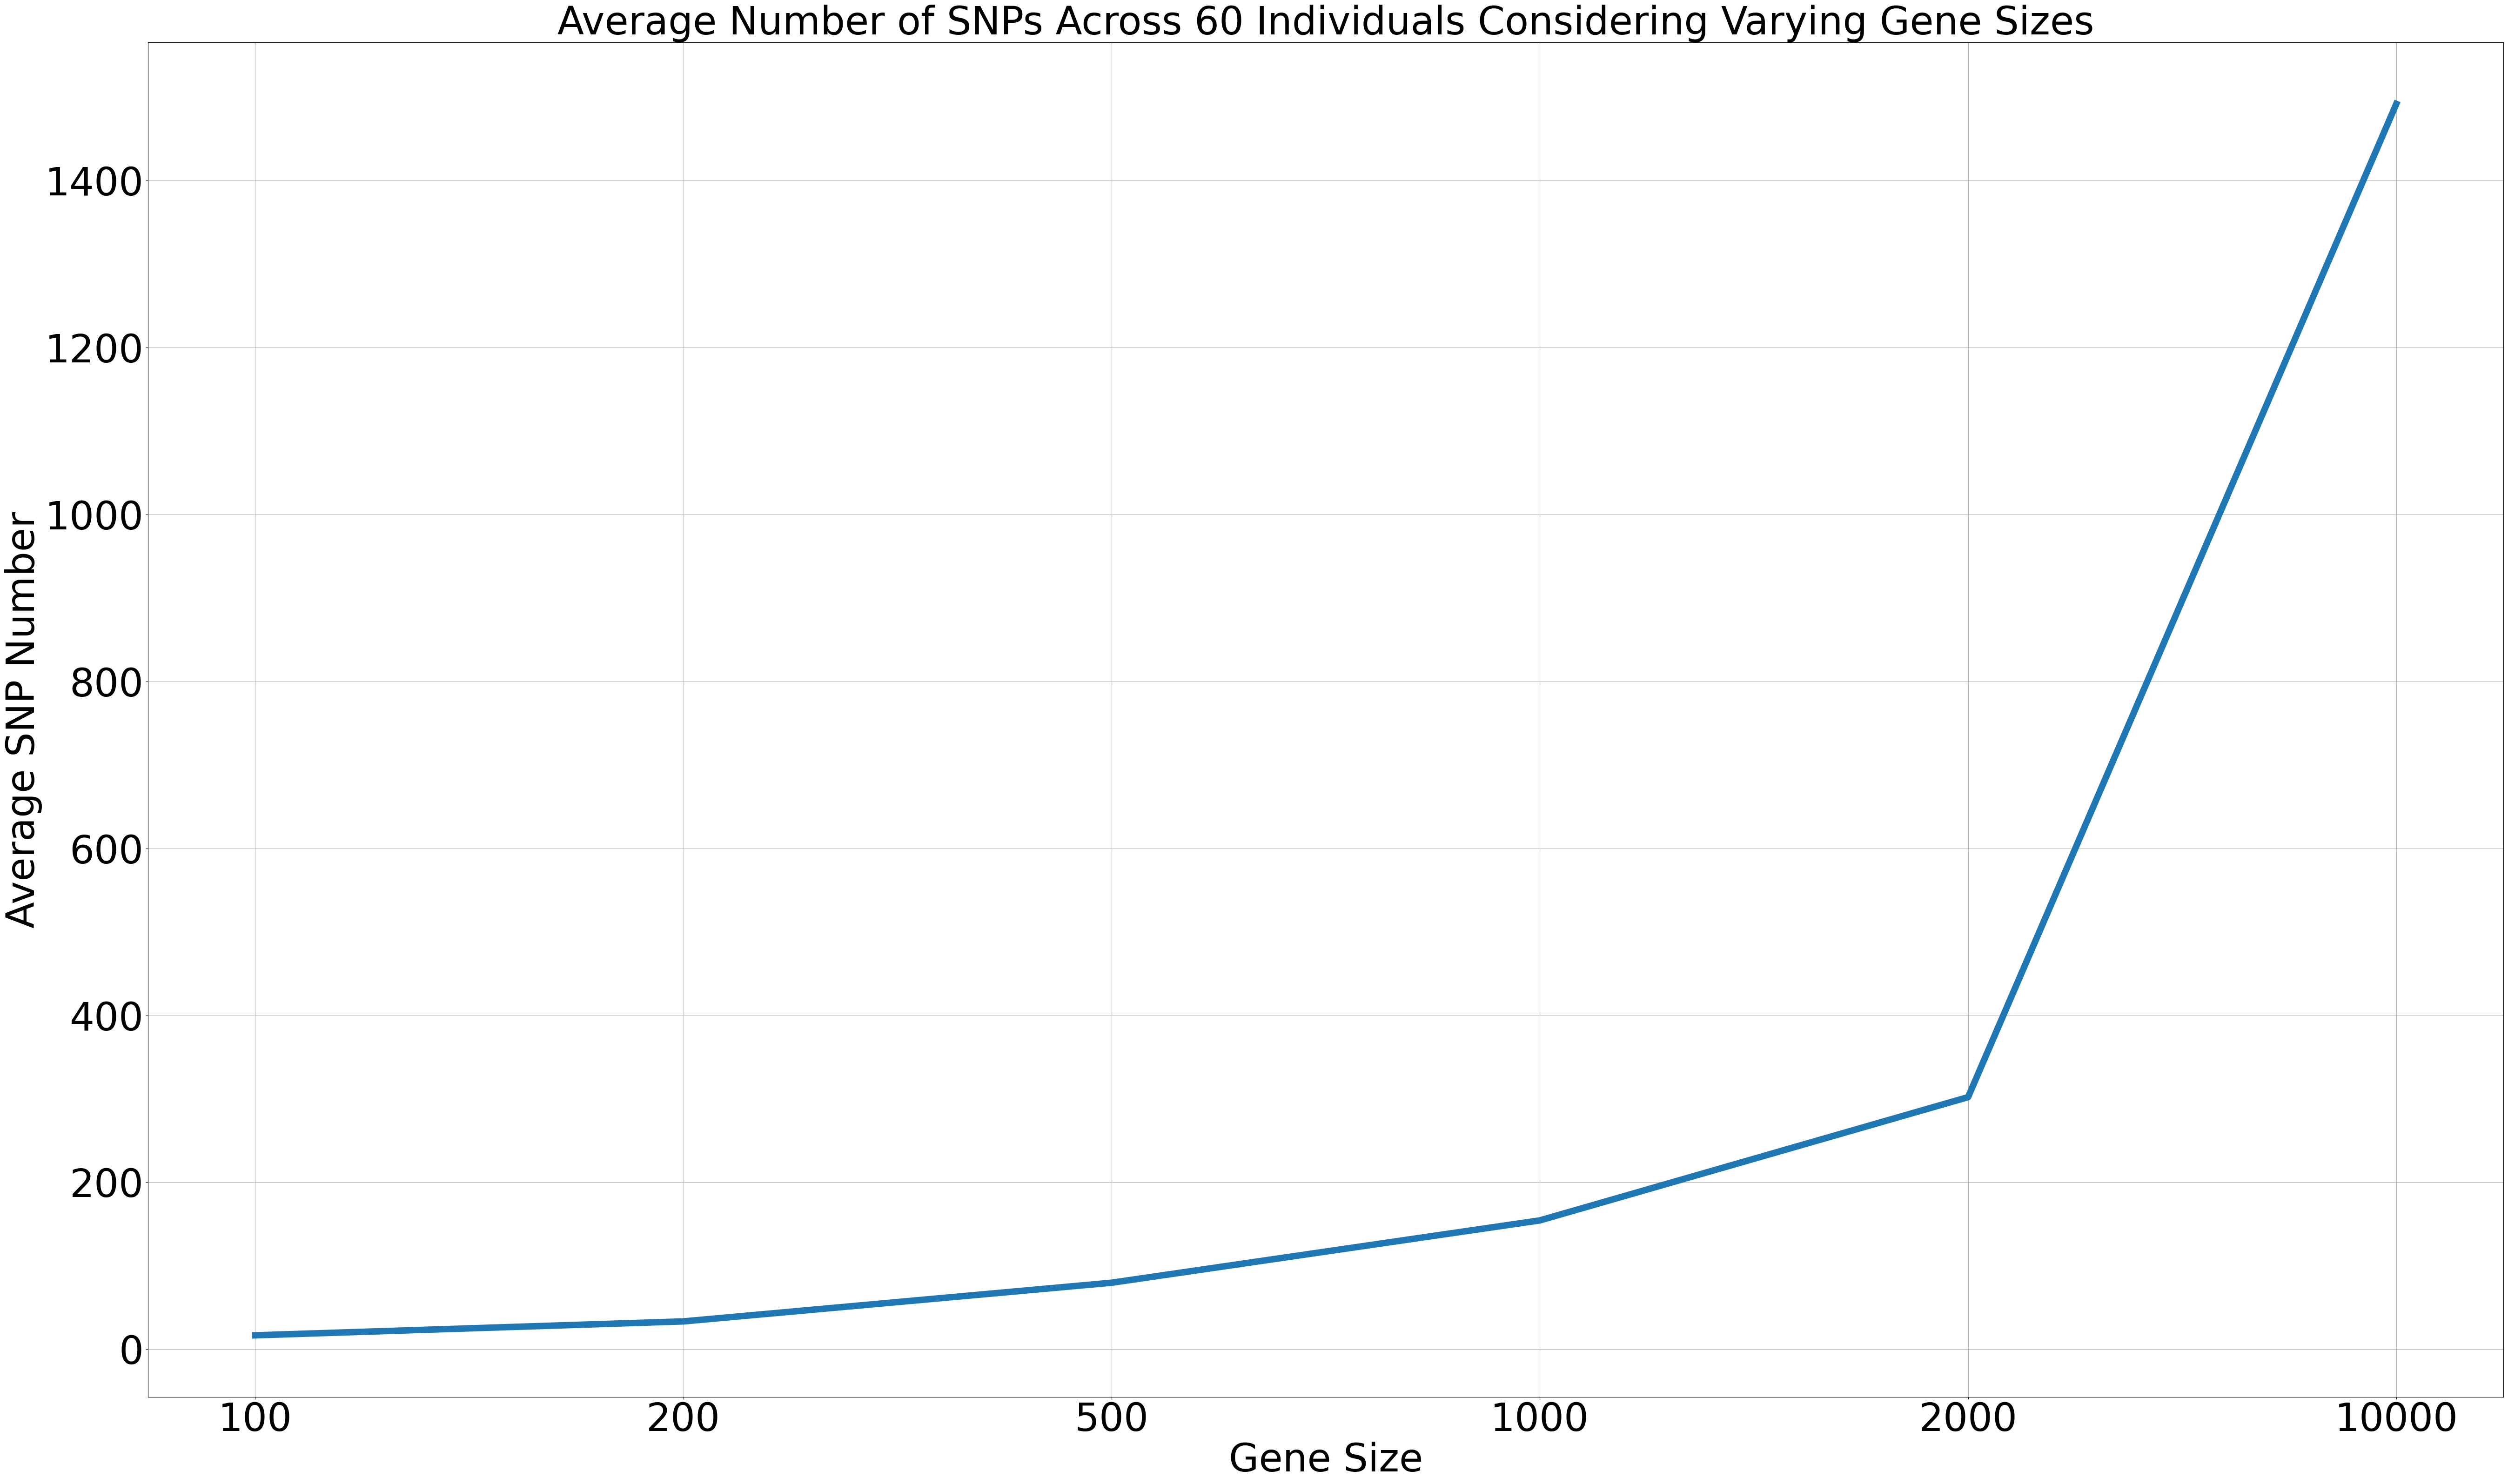

In [14]:
import numpy as np
import matplotlib.pyplot as plt

def plot_mean_line(mean_values, stage_labels=None, title="Average Number of SNPs Across 60 Individuals Considering Varying Gene Sizes"):
    """
    Plots a line plot of the mean values across stages.
    
    Parameters:
    - mean_values: A 1D NumPy array representing the mean values (shape = 10).
    - stage_labels: List of strings for the x-axis labels. If None, default "Stage 1", "Stage 2", etc. will be used.
    - title: Title of the plot.
    """
    
    # Default stage labels if not provided
    if stage_labels is None:
        stage_labels = [f"{i}" for i in [100, 200, 500, 1000, 2000, 10000]]

    # Create the plot
    plt.figure()
    plt.plot(stage_labels, mean_values, marker='o', linestyle='-')

    # Annotate the difference between the last two stages
    # diff = mean_values[-1] - mean_values[-2]
    # plt.annotate(f"Huge Difference: {diff:.0f}", 
    #              xy=(len(stage_labels)-1, mean_values[-1]), 
    #              xytext=(len(stage_labels)-2, mean_values[-2] + diff/2),
    #             #  arrowprops=dict(facecolor='red', shrink=0.05),
    #              fontsize=60,color='red')

    # Set labels and title
    plt.xlabel("Gene Size")
    plt.ylabel("Average SNP Number")
    plt.title(title)

    # Show grid and plot
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Example usage with random mean values
mean_values = np.random.rand(10) * 10  # Example mean values for 10 stages
plot_mean_line(np.mean(cumulative_ones[:,[100, 200, 500, 1000, 2000, 10000]], axis=0))


In [15]:
from ppo import PPO
from td import TD3
%load_ext autoreload
%autoreload 2

from env import Env

args=args_create()


def simulate(args, beacon_type, attacker_type, attacker_resume=None, beacon_resume=None):
    args.beacon_type = beacon_type 
    args.attacker_type = attacker_type 
    # args.beacon_agent = beacon_agent 
    env = Env(args, beacon, maf_values, binary)
    ################ PPO hyperparameters ################
    K_epochs = 300         # update policy for K epochs
    eps_clip = 0.1           # clip parameter for PPO
    gamma = 0.99                # discount factor

    lr_actor = 0.0001      # learning rate for actor network
    lr_critic = 0.0001        # learning rate for critic network

    i_episode = 0

    attacker_state_dim = 400
    attacker_action_dim = 50

    beacon_rewards = []
    attacker_rewards = []
    privacies = []
    utilities = []

    if attacker_type == "agent":
        attacker_agent = PPO(attacker_state_dim, attacker_action_dim, lr_actor, lr_critic, gamma, K_epochs, eps_clip, False, None)
        attacker_agent.load(attacker_resume)

    if beacon_type == "agent":
        state_dim = 18
        action_dim = 1
        beacon_agent = TD3(state_dim, action_dim, max_action=1)
        beacon_agent.load(beacon_resume)

    while i_episode < args.episodes:
        beacon_rewardss = []
        attacker_rewardss = []
        privaciess = []
        utilitiess = []
        for t in range(1, args.max_queries+1):
            if attacker_type == "agent" and beacon_type == "agent":
                beacon_state, rewards, done, pu  = env.step(attacker_agent=attacker_agent, beacon_agent=beacon_agent)
            elif attacker_type == "agent":
                beacon_state, rewards, done, pu  = env.step(attacker_agent=attacker_agent)
            elif beacon_type == "agent":
                beacon_state, rewards, done, pu  = env.step(beacon_agent=beacon_agent)
            else:
                beacon_state, rewards, done, pu  = env.step()

            # print(beacon_state[0])

            beacon_rewardss.append(rewards[0])
            attacker_rewardss.append(rewards[1])
            privaciess.append(pu[0])
            utilitiess.append(pu[1])
            if done:
                break
        
        beacon_rewards.append(beacon_rewardss)
        attacker_rewards.append(attacker_rewardss)
        privacies.append(privaciess)
        utilities.append(utilitiess)

        print("Victim: {} \t Current Episode Reward : {}".format(env.victim_id, rewards[1]))
        env.reset()
        i_episode += 1
    return beacon_rewards, attacker_rewards, privacies, utilities

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Namespace(data='/mnt/kerem/CEU', episodes=19, seed=3, evaluate=True, a_control_size=50, b_control_size=50, gene_size=100000, beacon_size=20, victim_prob=1, max_queries=100, attacker_type='optimal', beacon_type='truth', beacon_agent='td', pop_reset_freq=100000000, plot_freq=1, resume=None, results_dir='./results/simulation/run44', device=device(type='cuda', index=0))


In [16]:
evaluations = [
    {
        "beacon_type": "truth",
        "attacker_type": "random",
        "beacon_resume": None,
        "attacker_resume": None
    },

    {
        "beacon_type": "agent",
        "attacker_type": "random",
        "beacon_resume": "/data6/sobhan/Beacons/results/train/run34/weights",
        "attacker_resume": None
    },
    {
        "beacon_type": "random",
        "attacker_type": "random",
        "beacon_resume": None,
        "attacker_resume": None
    }
]

In [39]:
evaluations = [
    {
        "beacon_type": "truth",
        "attacker_type": "agent",
        "beacon_resume": None,
        "attacker_resume": "/data6/sobhan/Beacons/agents/Both/weights/PPO_attacker0.pth"
    },
    {
        "beacon_type": "agent",
        "attacker_type": "agent",
        "beacon_resume": "/data6/sobhan/Beacons/agents/Both/weights",
        "attacker_resume": "/data6/sobhan/Beacons/agents/Both/weights/PPO_attacker0.pth"
    },
    {
        "beacon_type": "random",
        "attacker_type": "agent",
        "beacon_resume": None,
        "attacker_resume": "/data6/sobhan/Beacons/agents/Mas/weights/PPO_attacker0.pth"
    },
    {
        "beacon_type": "random",
        "attacker_type": "agent",
        "beacon_resume": None,
        "attacker_resume": "/data6/sobhan/Beacons/agents/Both/weights/PPO_attacker0.pth"
    }
]

In [9]:
evaluations = [
    {
        "beacon_type": "agent",
        "attacker_type": "optimal",
        "beacon_resume": "/data6/sobhan/Beacons/agents/Beacon/weights",
        "attacker_resume": None
    },
    {
        "beacon_type": "agent",
        "attacker_type": "agent",
        "beacon_resume": "/data6/sobhan/Beacons/agents/Beacon/weights",
        "attacker_resume": "/data6/sobhan/Beacons/agents/Both/weights/PPO_attacker0.pth"
    },
    {
        "beacon_type": "agent",
        "attacker_type": "optimal",
        "beacon_resume": "/data6/sobhan/Beacons/agents/Both/weights",
        "attacker_resume": None
    },
    {
        "beacon_type": "agent",
        "attacker_type": "agent",
        "beacon_resume": "/data6/sobhan/Beacons/agents/Both/weights",
        "attacker_resume": "/data6/sobhan/Beacons/agents/Both/weights/PPO_attacker0.pth"
    },
]

In [ ]:
beacon_rewards=[]
attacker_rewards=[]
privacies=[]
utilities=[]

for eval in evaluations:
    print(eval)
    res = simulate(args, beacon_type=eval["beacon_type"], attacker_type=eval["attacker_type"], beacon_resume=eval['beacon_resume'], attacker_resume=eval["attacker_resume"])
    beacon_rewards.append(res[0])
    attacker_rewards.append(res[1])
    privacies.append(res[2])
    utilities.append(res[3])

{'beacon_type': 'truth', 'attacker_type': 'random', 'beacon_resume': None, 'attacker_resume': None}
ATTACKER TYPE:  random
./results/simulation/run44/logs/beacon_log.csv
./results/simulation/run44/logs/beacon_control_log.csv
./results/simulation/run44/logs/attacker_log.csv
./results/simulation/run44/logs/attacker_control_log.csv
==================================⬇️⬇️⬇️⬇️Episode: 1⬇️⬇️⬇️⬇️==============================
-------------------------
--------------------------------Actions---------------------------------
Attacker Action: Position 58986 with MAF: 0.0 and SNP: 0.0 and LRT: -0.0
Beacon Action: 1
Beacon State: [tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(1.), tensor(1.), tensor(1.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), 1.0]
Beacon utility reward: 1  privacy reward: 1.0
--------------------------------Actions---------------------------------
Attacker Action: Position 61048 with MAF: 0.0 

/mnt/sobhan/cpi/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


--------------------------------Actions---------------------------------
Attacker Action: Position 66941 with MAF: 0.158 and SNP: 0.0 and LRT: 0.0
Beacon Action: 0.013506684452295303
Beacon State: [tensor(0.1580), tensor(0.), tensor(0.), tensor(-0.0010), tensor(-0.0002), tensor(0.), tensor(0.9846), tensor(1.), tensor(1.), tensor(0.1400), tensor(0.), tensor(0.), tensor(0.), tensor(-0.0010), tensor(-0.0001), tensor(-0.0010), tensor(-0.0001), 1.0]
Beacon utility reward: 0.013506684452295303  privacy reward: 1.0
--------------------------------Actions---------------------------------
Attacker Action: Position 59361 with MAF: 0.155 and SNP: 0.0 and LRT: 0.0
Beacon Action: 0.6544480919837952
Beacon State: [tensor(0.1550), tensor(0.), tensor(0.9713), tensor(-0.0012), tensor(0.9711), tensor(0.), tensor(1.9569), tensor(1.), tensor(1.), tensor(0.2600), tensor(-0.0010), tensor(-0.0001), tensor(-0.0010), tensor(-0.0022), tensor(-0.0005), tensor(-0.0022), tensor(-0.0005), 0.5067533422261477]
Beacon

In [50]:
import numpy as np

def pad_to_max_length(data, max_len=100, value=np.nan):
    padded_data = [[sublst + [value] * (max_len - len(sublst)) for sublst in lst] for lst in data]
    return np.array(padded_data)


In [51]:
padded_beacon_rewards = pad_to_max_length(beacon_rewards)
padded_attacker_rewards = pad_to_max_length(attacker_rewards)
padded_privacies = pad_to_max_length(privacies)
padded_utilities = pad_to_max_length(utilities)

In [52]:
padded_beacon_rewards.shape, padded_attacker_rewards.shape, padded_privacies.shape

((3, 29, 100), (3, 29, 100), (3, 29, 100))

In [53]:
%load_ext autoreload
%autoreload 2
from utils import plot_violinplot, plot_boxplot, line_plot, scatter_plot

labels = ["Truth", "Agent", "Random"]  # Define your labels
# labels = ["Truth", "Agent-Optimal Attacker", "Agent-Agent Attacker", "Random"]  # Define your labels
# labels = ["Optimal Attacker-Beacon Agent A", "Agent Attacker-Beacon Agent A", "Optimal Attacker-Beacon Agent B", "Agent Attacker-Beacon Agent B",]  # Define your labels

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [54]:
nan_count = np.isnan(padded_beacon_rewards).sum(axis=1)
# nan_count = (padded_beacon_rewards==0).sum(axis=1)

In [55]:
nan_count

array([[0, 0, 0, 0, 0, 1, 2, 2, 2, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
        7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
        7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
        7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7],
       [0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0,

Scatter Plots

/data6/sobhan/Beacons/utils.py:520: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  class_handles = [mpatches.Patch(color=color_palette[i], label=labels[i], edgecolor='black') for i in range(classes)]


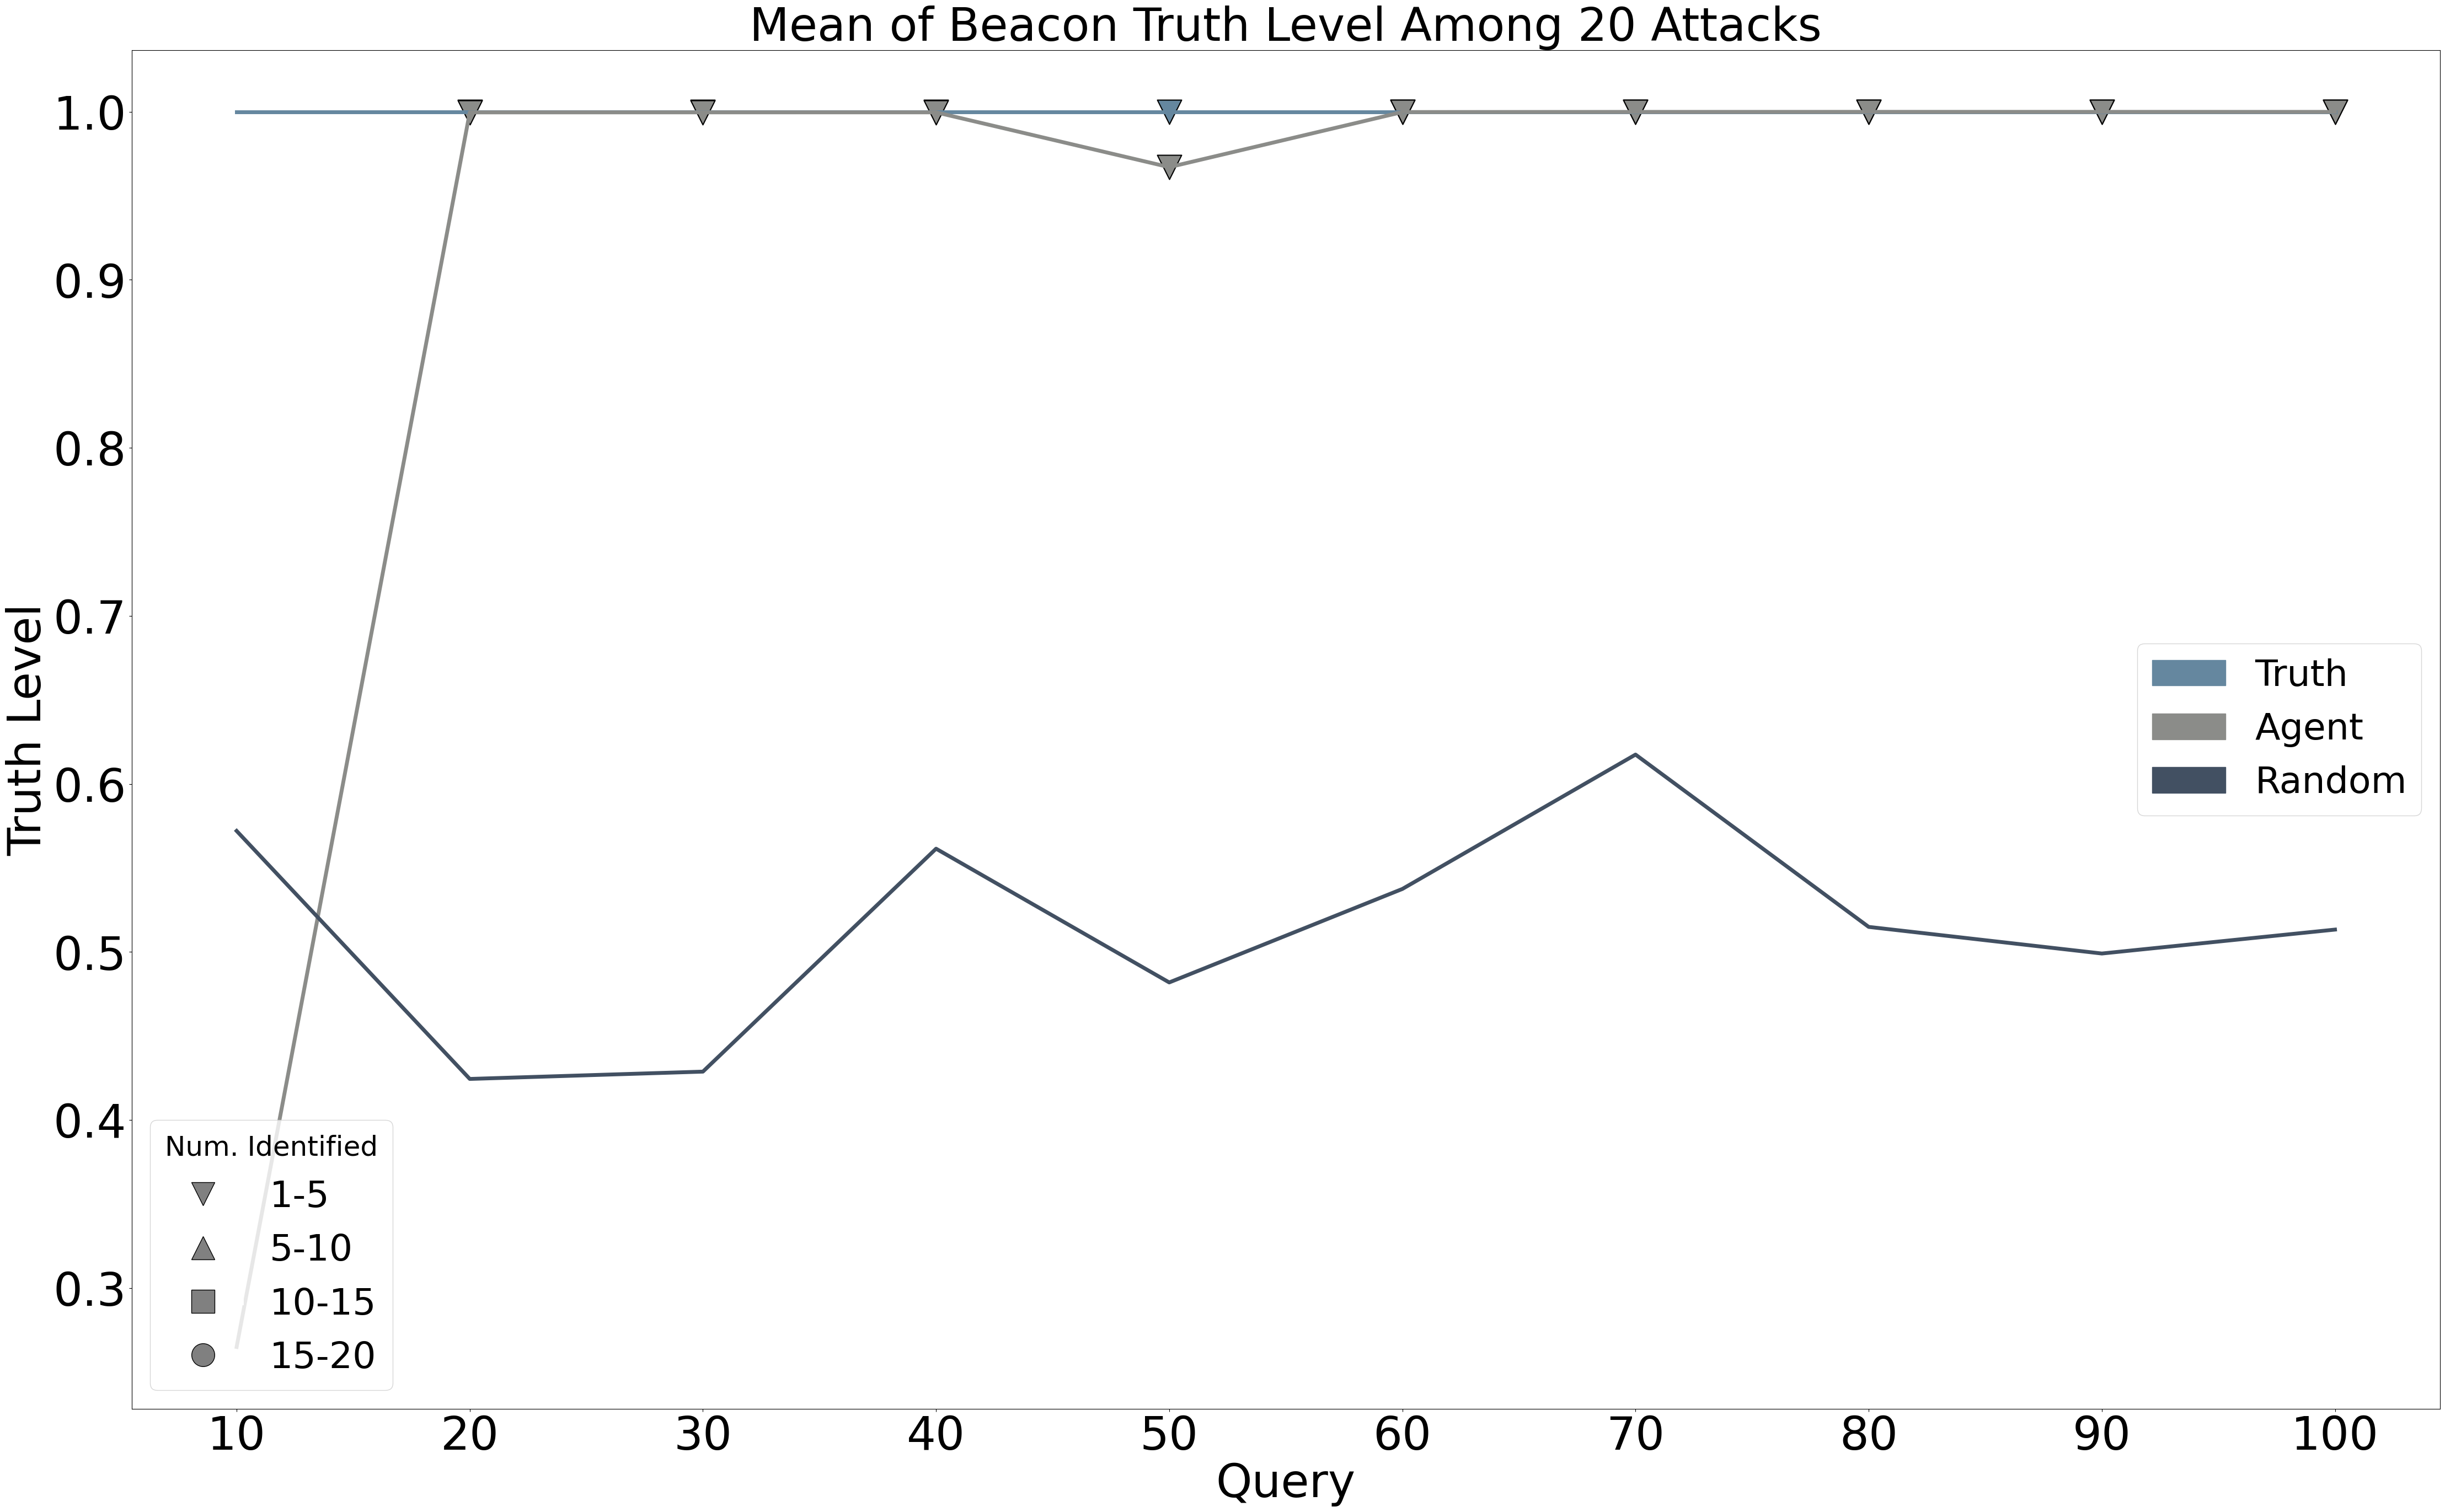

In [56]:
padded_utilities = pad_to_max_length(utilities, value=1)
# nan_count = (padded_utilities==0).sum(axis=1)
# nan_count = np.isnan(padded_utilities).sum(axis=1)
scatter_plot(np.nanmean(padded_utilities, axis=1)[:, ::10], nan_count[:,::10], labels, title="Mean of Beacon Truth Level Among 20 Attacks", ylabel="Truth Level")

In [42]:
np.nanmean(padded_utilities, axis=1)[:, ::10]

array([[1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00],
       [3.63519630e-06, 7.64806735e-01, 8.70054915e-01, 9.20438044e-01,
        9.22982966e-01, 8.92439779e-01, 9.45880571e-01, 9.63069998e-01,
        9.76981453e-01, 9.74112566e-01],
       [4.55539259e-01, 4.07453986e-01, 4.35244645e-01, 4.64892703e-01,
        4.08274410e-01, 4.25367736e-01, 4.11144708e-01, 3.90438974e-01,
        4.34604438e-01, 4.53521824e-01]])

In [43]:
nan_count

array([[ 0, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29,
        29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29,
        29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29,
        29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29,
        29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29,
        29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29,
        29, 29, 29, 29],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0],
       [ 0,  4,  4,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
         5,  5

/data6/sobhan/Beacons/utils.py:520: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  class_handles = [mpatches.Patch(color=color_palette[i], label=labels[i], edgecolor='black') for i in range(classes)]


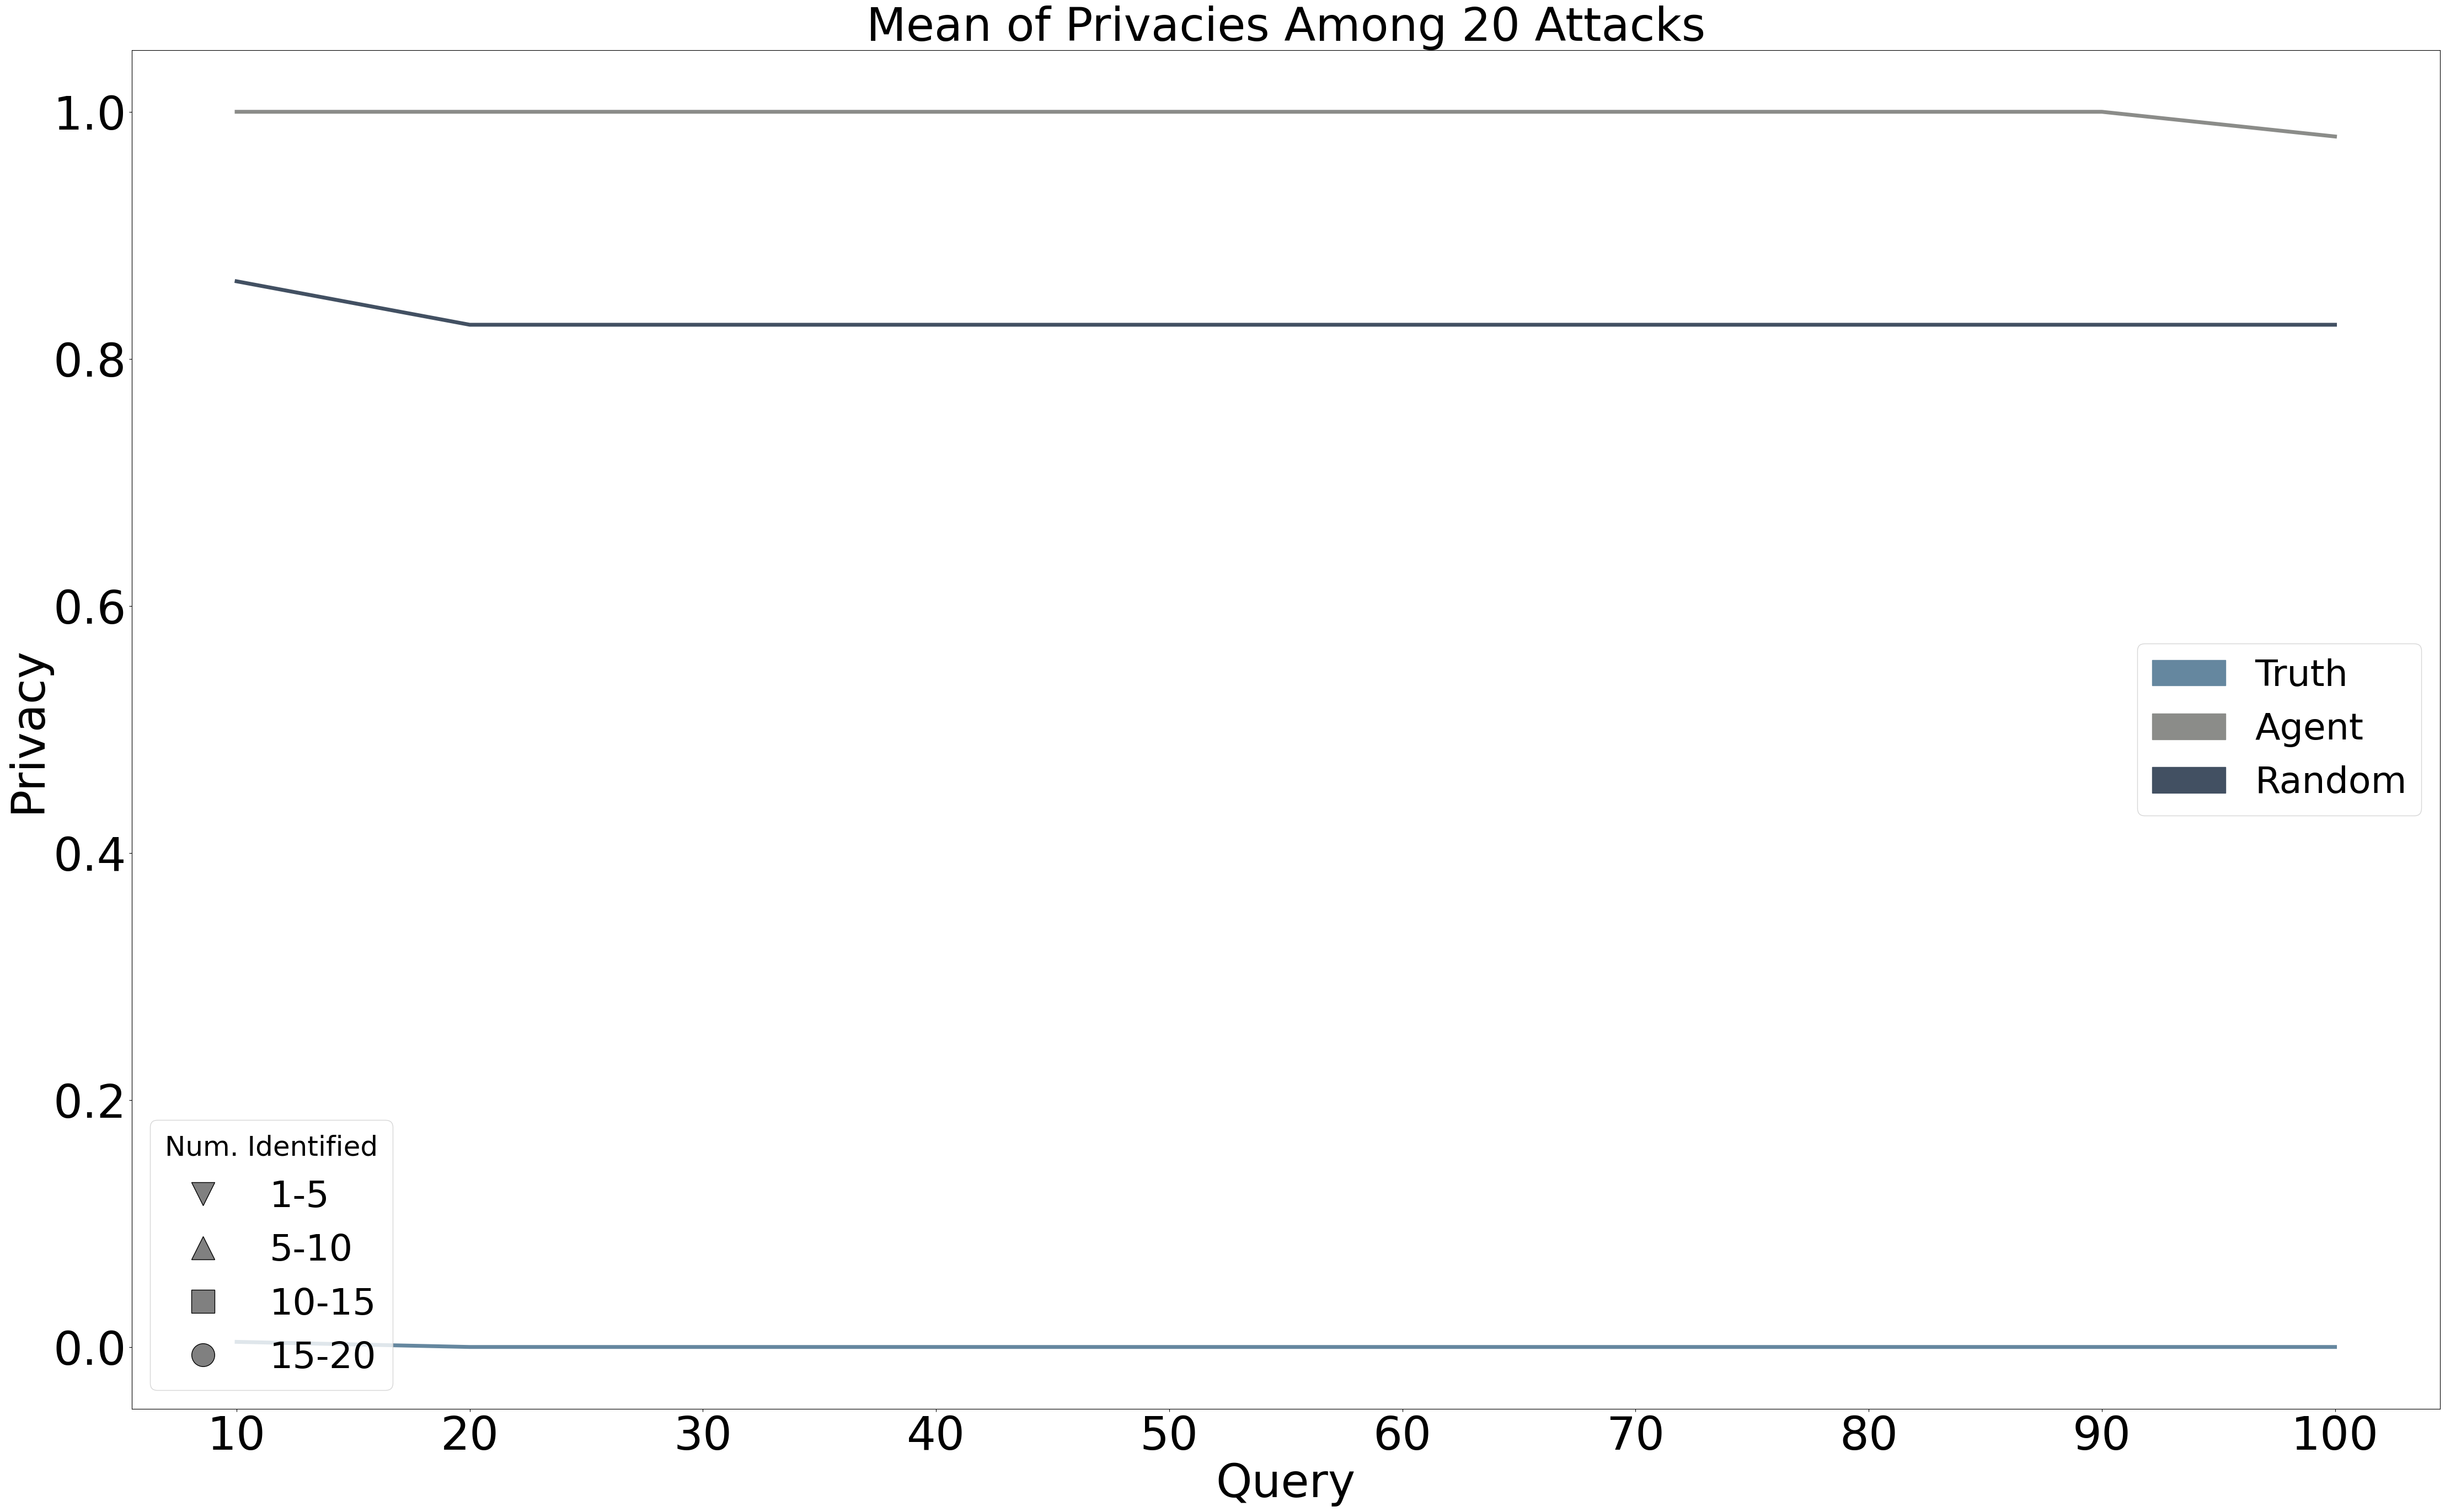

In [45]:
padded_privacies = pad_to_max_length(privacies, value=0)
nan_count = (padded_beacon_rewards==0).sum(axis=1)
scatter_plot(np.nanmean(padded_privacies, axis=1)[:, ::10], nan_count[:,::10], labels, title="Mean of Privacies Among 20 Attacks", ylabel="Privacy")

In [ ]:
padded_attacker_rewards = np.clip(pad_to_max_length(attacker_rewards, value=0), None, 0)

# padded_attacker_rewards +=1
nan_count = (padded_beacon_rewards==0).sum(axis=1)
scatter_plot(np.nanmean(padded_attacker_rewards, axis=1)[:, ::10], nan_count[:,::10], labels, title="Mean of Attacker Rewards Among 20 Attacks", ylabel="Reward")

Line Plots

In [ ]:
padded_beacon_rewards = pad_to_max_length(beacon_rewards, value=0)
line_plot(np.mean(padded_beacon_rewards, axis=1)[:, ::9], labels, title="Mean of Beacon Rewards Among 20 Attacks", ylabel="Reward")

In [ ]:
padded_beacon_rewards = pad_to_max_length(beacon_rewards, value=np.nan)
line_plot(np.nanmean(padded_beacon_rewards, axis=1)[:, ::9], labels, title="Mean of Beacon Rewards Among 20 Attacks", ylabel="Reward")

In [ ]:
padded_attacker_rewards = np.clip(pad_to_max_length(attacker_rewards, value=np.nan), None, 0)
padded_attacker_rewards[padded_attacker_rewards < -2] += 5
scatter_plot(np.nanmean(padded_attacker_rewards, axis=1)[:4, ::9], nan_count[:,::9], labels, title="Mean of Attacker Rewards Among 20 Attacks", ylabel="Reward")

In [ ]:
line_plot(np.mean(padded_utilities, axis=1)[:, ::9], labels, title="Mean of Beacon Truth Level Among 20 Attacks", ylabel="Truth Level")

In [ ]:
padded_utilities = pad_to_max_length(utilities, value=np.nan)
scatter_plot(np.nanmean(padded_utilities, axis=1)[:3, ::9], nan_count[:,::9], labels, title="Mean of Beacon Truth Level Among 20 Attacks", ylabel="Truth Level")

In [ ]:
padded_privacies = pad_to_max_length(privacies, value=np.nan)
scatter_plot(np.nanmean(padded_privacies, axis=1)[:3, ::9], nan_count[:,::9], labels, title="Mean of Beacon Truth Level Among 20 Attacks", ylabel="Truth Level")

In [ ]:
plot_boxplot(padded_utilities[:, :, ::9], labels, title="Distribution of Beacon Rewards Against the Agent Attacker", ylabel="Reward")
plot_violinplot(padded_utilities[:, :, ::9], labels, title="Distribution of Beacon Rewards Against the Agent Attacker", ylabel="Reward")

In [ ]:
plot_boxplot(np.clip(padded_beacon_rewards[:, :, ::9], 0, None), labels, title="Distribution of Beacon Rewards Against the Agent Attacker", ylabel="Reward")
plot_violinplot(np.clip(padded_beacon_rewards[:, :, ::9], 0, None), labels, title="Distribution of Beacon Rewards Against the Agent Attacker", ylabel="Reward")

In [ ]:
# plot_violinplot(np.clip(padded_beacon_rewards[:, :, ::9], 0, None), labels, title="Distribution of Beacon Rewards Against the Agent Attacker", ylabel="Reward")
plot_violinplot(np.clip(padded_beacon_rewards[:, :, ::9], 0, None), labels, title="Distribution of Beacon Rewards Against the Agent Attacker", ylabel="Reward", scatter_data = nan_count[:,::9])

In [ ]:
plot_boxplot(np.clip(padded_attacker_rewards[:, :, ::9], None, 0), labels, title="Distribution of Attacker Rewards Against the Agent Attacker", ylabel="Reward")
plot_violinplot(np.clip(padded_attacker_rewards[:, :, ::9], None, 0), labels, title="Distribution of Attacker Rewards Against the Agent Attacker", ylabel="Reward")

In [ ]:
padded_attacker_rewards = pad_to_max_length(attacker_rewards, value=np.nan)

padded_attacker_rewards[padded_attacker_rewards < -2] += 5
padded_attacker_rewards[1, :, :], padded_attacker_rewards[2, :, :] = padded_attacker_rewards[2, :, :], padded_attacker_rewards[1, :, :].copy()
labels = ["Optimal Attacker-Beacon Agent B", "Agent Attacker-Beacon Agent B",]  # Define your labels
plot_boxplot(np.clip(padded_attacker_rewards[1::2, :, ::9], None, 0), labels, title="Distribution of Attacker Rewards Against the Agent Attacker", ylabel="Reward")
plot_violinplot(np.clip(padded_attacker_rewards[1::2, :, ::9], None, 0), labels, title="Distribution of Attacker Rewards Against the Agent Attacker", ylabel="Reward")

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


params = {'legend.fontsize': 48,
        'figure.figsize': (54, 32),
        'axes.labelsize': 60,
        'axes.titlesize':60,
        'xtick.labelsize':60,
        'ytick.labelsize':60,
        'lines.linewidth': 10}

plt.rcParams.update(params)

# Create sample data (two arrays)
data1 = np.random.normal(60, 10, size=100)
data2 = np.random.normal(65, 15, size=100)
data3 = np.random.normal(55, 8, size=100)

# Combine the data into one dataset
data = [data1, data2, data3]
labels = ['Generated', 'Natural']




def plot_violin_compare(natural, generated, labels, filename):
    # Create the violin plot
    plt.figure()
    data = [natural, generated]
    sns.violinplot(data=data, inner='box', palette=['#4F6367', '#A4B494', '#D4A5A5'])

    # Customizing the plot to resemble the example
    plt.xticks([0, 1], labels)
    plt.yticks()
    # plt.ylim(40, 90)
    plt.ylabel('', )
    plt.title('A',loc='left')

    # Show plot
    plt.tight_layout()
    plt.savefig(filename)
    plt.close()
    # plt.show()

plot_violin_compare(data1, data2, labels)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

def violin_plot(data, edge_color, fill_color, position, ax):
    parts = ax.violinplot(data, positions=[position], widths=0.5, showmedians=True)
    
    for pc in parts['bodies']:
        pc.set_facecolor(fill_color)
        pc.set_edgecolor(edge_color)
        pc.set_linewidth(1)
        pc.set_alpha(1)
    
    if 'cmedians' in parts:
        parts['cmedians'].set_color(edge_color)
        parts['cmedians'].set_linewidth(1)
    
    for partname in ('cbars', 'cmins', 'cmaxes'):
        vp = parts[partname]
        vp.set_edgecolor(edge_color)
        vp.set_linewidth(1)


def plot_violinplot(data, scatter_data, labels, title, ylabel):

    def scatter_plot(ax, x_positions, y_data, size_data, color_palette, labels):
        # Define marker size groups
        size_ranges = [(1, 5), (5, 10), (10, 15), (15, 20)]
        marker_sizes = [200, 400, 600, 800]  # Corresponding marker sizes for the ranges
        size_labels = ["1-5", "5-10", "10-15", "15-20"]  # Labels for legend

        classes, stages = y_data.shape

        # Loop through each class
        for class_idx in range(classes):
            y_class_data = y_data[class_idx, :]  # y-axis data for the class
            size_class_data = size_data[class_idx, :]  # Size data for the class
            edge_color = 'black'
            marker_color = color_palette[class_idx]
            marker_style = 'o'

            # Assign marker sizes based on the size ranges
            marker_sizes_class = np.zeros_like(size_class_data)
            for i, size_range in enumerate(size_ranges):
                mask = (size_class_data >= size_range[0]) & (size_class_data < size_range[1])
                marker_sizes_class[mask] = marker_sizes[i]

            # Scatter plot with custom marker sizes
            ax.scatter(x_positions[class_idx], y_class_data, s=marker_sizes_class,
                    color=marker_color, edgecolor=edge_color, marker=marker_style, linewidth=1.5)
            # ax.plot(x_positions[class_idx], y_class_data, color=marker_color, linewidth=5)

        # Legend for the marker sizes
        size_handles = [plt.Line2D([], [], color='w', marker='o', markersize=np.sqrt(size/2),
                                markerfacecolor='gray', label=label, markeredgecolor='black')
                        for size, label in zip(marker_sizes, size_labels)]
        legend1 = ax.legend(size_handles, size_labels, title="Num. Identified", loc="lower left", title_fontsize=12)
        ax.add_artist(legend1)
    """
    Generates a violin plot with overlayed scatter points based on a secondary array for marker sizes.
    
    Parameters:
    data (numpy array): A 3D numpy array with shape (classes, samples, stages).
    scatter_data (numpy array): A 2D numpy array with shape (classes, stages) for marker sizes.
    """
    color_palette = ["#65879F", "#8B8C89", "#425062", "#8F5C5C", "#CFACAC"]
    classes, samples, stages = data.shape
    
    fig, ax = plt.subplots()

    # Adjust x-positions for each stage and class
    x_positions = []
    for stage in range(stages):
        x_positions.append(np.arange(classes) + stage * (classes + 1))

    x_positions = np.array(x_positions).T  # Transpose to match class and stage positions

    for class_idx in range(classes):
        class_data = data[class_idx]  # shape (samples, stages)
        
        for stage in range(stages):
            stage_data = class_data[:, stage]
            position = x_positions[class_idx, stage]
            edge_color = 'black'
            fill_color = color_palette[class_idx]
            
            violin_plot(stage_data, edge_color, fill_color, position, ax)
    
    # Overlay scatter plot for marker sizes using the median of each stage
    scatter_plot(ax, x_positions, np.median(data, axis=1), scatter_data, color_palette, labels)

    ax.set_xlabel('Query')
    ax.set_ylabel(ylabel)
    ax.set_title(title)

    # Setting the class labels legend
    class_handles = [mpatches.Patch(color=color_palette[i], label=labels[i], edgecolor='black') for i in range(classes)]
    ax.legend(class_handles, labels, loc="center right")
    
    plt.show()

# Sample Data
np.random.seed(42)
data = np.random.rand(5, 19, 6) * 50  # 5 classes, 19 samples, 6 stages
scatter_data = np.random.randint(0, 20, (5, 6))  # 5 classes, 6 stages

# Labels
labels = [f'Class {i+1}' for i in range(5)]

# Run the plot
plot_violinplot(data, scatter_data, labels, "Violin Plot with Scatter", "Value")


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Generate a sample 3D numpy array of size (5, 19, 6) for the violin plot
np.random.seed(42)
data = np.random.rand(5, 19, 6) * 50  # 5 classes, 19 samples, 6 stages

# Generate a sample 2D numpy array of size (5, 6) for scatter marker sizes
scatter_data = np.random.randint(0, 20, (5, 6))  # 5 classes, 6 stages

# Define labels for the classes
labels = [f'Class {i+1}' for i in range(5)]

# Run the plot function
plot_violinplot(data, scatter_data, labels, "Violin Plot with Scatter", "Value")
